# Extract Twitter Dataset with API

Twitter offers the past seven days of data on their free API tier, so we will go back in 60-minute windows and extract ~100 tweets from within each of these windows. Requires bearer tokens as from registration process with Twitter for developer access.

In [ ]:
from datetime import datetime, timedelta
import requests
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [ ]:
with open('bearer_token.txt') as fp:
    BEARER_TOKEN = fp.read()

In [ ]:
endpoint = 'https://api.twitter.com/2/tweets/search/recent'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(amazon OR aws OR jeff bezos) (lang:en)',
    'max_results': '100',
    'tweet.fields': 'created_at, lang'}

In [ ]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'

In [ ]:
def time_periods(now, mins):
    now = datetime.strptime(now, dtformat)
    intervals_time = now - timedelta(minutes=mins) # time series at mins intervals
    return intervals_time.strftime(dtformat)

In [ ]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=7)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API

In [ ]:
df = pd.DataFrame()

In [ ]:
def twitter_data(tweet):
    data = {
        'id': tweet['id_str'],
        'created_at': tweet['created_at'],
        'text': tweet['full_text']
    }
    return data

In [ ]:
while True:
    if datetime.strptime(now, dtformat) < last_week:
        break # loop based on earliest time
      
    pre60 = time_periods(now, 60)
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)
    now = pre60

    for tweet in response.json()['data']:
        row = twitter_data(tweet)
        df = df.append(row, ignore_index=True)

# Beautiful Soup

Extraction from websites based on html/xml format - e.g. see code referring to find_all by class. Understand structure of website and develop code for that to scrap information. It creates a parse tree from page source code that can be used to extract data in a hierarchical and more readable manner.

In [ ]:
# FOR REFERENCE
seed_urls = ['https://inshorts.com/en/read/financial']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

# Gathering Financial News / Sentiment Analysis with BERT

Historical analyst headlines and financial news headlines over several years on a sample of listed companies. Sentiment analysis using flair; classification into positive / negative with probability.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
root_folder='/content/drive/My Drive/DataAnalysis'

In [ ]:
data = pd.read_csv(root_folder+'/analyst_ratings_processed.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400469 entries, 0 to 1400468
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1399180 non-null  float64
 1   title       1400469 non-null  object 
 2   date        1399180 non-null  object 
 3   stock       1397891 non-null  object 
dtypes: float64(1), object(3)
memory usage: 42.7+ MB


In [ ]:
data = data.dropna(axis=0)

In [ ]:
data['date'] = data['date'].str.split(' ').str[0]
data['date'] = pd.Series(pd.to_datetime(data['date'], format='%Y-%m-%d')) # 2020-06-05 10:30:00-04:00

In [ ]:
data = data.drop('Unnamed: 0', axis=1)

## Flair / DistilBERT

This model splits the text into character-level tokens and uses the DistilBERT model to make predictions.The advantage of working at the character-level (as opposed to word-level) is that words that the network has never seen before can still be assigned a sentiment. DistilBERT is a distilled version of the powerful BERT transformer model

In [ ]:
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-02-20 22:01:09,439 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
data = data.sample(n = 1000, replace = False)
data['text_clean'] = data['title'].apply(lambda x : text_cleaner(x))

In [ ]:
data['text_obj'] = data['text_clean'].apply(lambda x : flair.data.Sentence(x))
data['text_obj'].apply(lambda x : sentiment_model.predict(x))
data['score'] = data['text_obj'].apply(lambda x : x.labels[0].score)
data['value'] = data['text_obj'].apply(lambda x : x.labels[0].value)

In [ ]:
data

,title,date,stock,text_clean,text_obj,score,value
336161,Diebold's Planned Acquisition Of Wincor Nixdor...,2016-05-31,DBD,diebold s planned acquisition of wincor nixdor...,"(Token: 1 diebold, Token: 2 s, Token: 3 planne...",0.556393,POSITIVE
570059,Atlantic Equities Downgrades Garmin to Neutral...,2015-02-20,GRMN,atlantic equities downgrades garmin to neutral...,"(Token: 1 atlantic, Token: 2 equities, Token: ...",0.998690,NEGATIVE
1264993,TherapeuticsMD Reports Resubmission Of NDA For...,2017-11-29,TXMD,therapeuticsmd reports resubmission of nda for...,"(Token: 1 therapeuticsmd, Token: 2 reports, To...",0.984767,POSITIVE
478804,FAA To Streamline Fire Regulations For Cargo C...,2019-07-03,FDX,faa to streamline fire regulations for cargo c...,"(Token: 1 faa, Token: 2 to, Token: 3 streamlin...",0.790327,POSITIVE
1232600,"Earnings Scheduled For February 25, 2014",2014-02-25,TOL,earnings scheduled for february,"(Token: 1 earnings, Token: 2 scheduled, Token:...",0.872605,POSITIVE
...,...,...,...,...,...,...,...
1036042,American Petro-Hunter's Sacramento Gas Project...,2009-08-10,Q,american petro hunter s sacramento gas project...,"(Token: 1 american, Token: 2 petro, Token: 3 h...",0.612436,POSITIVE
1119241,Morning Market Losers,2013-06-10,SHI,morning market losers,"(Token: 1 morning, Token: 2 market, Token: 3 l...",0.999858,NEGATIVE
555722,Mid-Morning Market Update: Markets Open Lower;...,2016-06-10,GNW,mid morning market update markets open lower ...,"(Token: 1 mid, Token: 2 morning, Token: 3 mark...",0.995033,NEGATIVE
137174,Shares of several Brazilian bank stocks tradin...,2019-03-28,BBD,shares of several brazilian bank stocks tradin...,"(Token: 1 shares, Token: 2 of, Token: 3 severa...",0.992516,POSITIVE


## FinBERT

*   Original BERT training Data English Wikipedia and BookCorpus (Zhu et al., 2015)
*   Finance Articles from Yahoo Finance
*   Financial News from Financial Web
*   Question-Answer pairs about financial issues from Reddit

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [ ]:
labels = {0:'neutral', 1:'positive',2:'negative'}

In [ ]:
data['text_obj_finBERT'] = data['text_clean'].apply(lambda x : tokenizer(x, return_tensors="pt", padding=True))
data['text_obj_finBERT'].apply(lambda x : finbert(**inputs)[0])
data['sentiment_finBERT'] = data['text_obj_finBERT'].apply(lambda x : labels[np.argmax(x.detach().numpy())]

# Financial News Analysis

**Text-wranging and pre-processing.** Approached from a detailed perspective in contraction mapping, lemmatisation and stemming. Aim to standardise corpus and minimise vocabulary size for deep learning models or extractive techniques.

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+", '', newString)
    newString = re.sub(r"(?i)@[a-z0-9_]+", '', newString)
    newString = re.sub('[^a-zA-Z\s]', ' ', newString)

    return newString

General cleaning technique above based on regex. e.g. r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+" removes all such special characters. And final cleaning function to remove all non alpha-numerical characters. Only requires care in certain special characters needing to be replaced by space (e.g. "-") and others by BLANK.

In [ ]:
from bs4 import BeautifulSoup
import unicodedata

In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [ ]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

**Word stems** are also known as the base form of a word, and we can create new words by attaching affixes to them in a process known as inflection.

In [ ]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

**Lemmatization** is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem. The difference being that the root word is always a lexicographically correct word

In [ ]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

**Stopwords** - typically, these can be articles, conjunctions, prepositions and so on. Some examples of stopwords are a, an, the, and the like.

In [ ]:
def remove_stopwords_shortwords(text, length):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]

    long_words = []
    prev_word = []
    for i in filtered_tokens:
        if i not in prev_word and len(i) >= length:
            long_words.append(i)
            prev_word = [i]    
    return (" ".join(long_words)).strip()

**General function** to combine preprocessing steps. Also important to be able to toggle functions as for part-of-speech analysis, we **do not want to lower case text** or lemmatize/stem due to the change in grammatical structure.

In [ ]:
def normalize_corpus(corpus, html_stripping=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, simple_stemmer=True, 
                     remove_stopwords_shortwords=True):
    
    normalized_corpus = []

    for doc in corpus:
        if html_stripping:
            doc = strip_html_tags(doc)
        if accented_char_removal:
            doc = remove_accented_chars(doc)  
        if text_lower_case:
            doc = doc.lower()
        if text_lemmatization:
            doc = lemmatize_text(doc)
        if simple_stemmer:
            doc = simple_stemmer(doc)
        if remove_stopwords_shortwords:
            doc = remove_stopwords_shortwords(doc)
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        normalized_corpus.append(doc)
    
    return normalized_corpus

## Language Syntax and Structure

**N(oun)**: This usually denotes words that depict some object or entity, which may be living or nonliving.

**V(erb)**: Verbs are words that are used to describe certain actions, states, or occurrences. There are a wide variety of further subcategories, such as auxiliary, reflexive, and transitive verbs (and many more).

**Adj(ective)**: Adjectives are words used to describe or qualify other words, typically nouns and noun phrases. The POS tag symbol for adjectives is ADJ.

**Adv(erb)**: Adverbs usually act as modifiers for other words including nouns, adjectives, verbs, or other adverbs. The phrase very beautiful flower has the adverb (ADV) very, which modifies the adjective (ADJ) beautiful , indicating the degree to which the flower is beautiful. The POS tag symbol for adverbs is ADV.

Further include pronouns, prepositions, interjections, conjunctions, determiners, and many others. Plus each POS tag like the noun (N) can be further subdivided into categories like singular nouns (NN), singular proper nouns (NNP), and plural nouns (NNS).

In [ ]:
corpus = normalize_corpus(data['title'], text_lower_case=False, 
                          text_lemmatization=False, simple_stemmer=False, remove_stopwords_shortwords=False)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://inthemoneystocks.com/n_rant_and_rave_blog_single.php?id=8922" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.inthemoneystocks.com/n_rant_and_rave_blog_single.php?id=8709" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [ ]:
# Example
sentence = str(data.iloc[1].title)
sentence_nlp = nlp(sentence)

# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Stocks,NNS
1,That,WDT
2,Hit,VBP
3,52-Week,JJ
4,Highs,NNP
5,On,IN
6,Wednesday,NNP


## Shallow Parsing

Noun phrase (NP): These are phrases where a noun acts as the head word. Noun phrases act as a subject or object to a verb.

Verb phrase (VP): These phrases are lexical units that have a verb acting as the head word. Usually, there are two forms of verb phrases. One form has the verb components as well as other entities such as nouns, adjectives, or adverbs as parts of the object.

Adjective phrase (ADJP): These are phrases with an adjective as the head word. Their main role is to describe or qualify nouns and pronouns in a sentence, and they will be either placed before or after the noun or pronoun.

Adverb phrase (ADVP): These phrases act like adverbs since the adverb acts as the head word in the phrase. Adverb phrases are used as modifiers for nouns, verbs, or adverbs themselves by providing further details that describe or qualify them.

Prepositional phrase (PP): These phrases usually contain a preposition as the head word and other lexical components like nouns, pronouns, and so on. These act like an adjective or adverb describing other words or phrases.

In [ ]:
import nltk
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


Two chunking utility functions, tree2conlltags , to get triples of word, tag, and chunk tags for each token, and conlltags2tree to generate a parse tree from these token triples. The chunk tags use the IOB format. This notation represents Inside, Outside, and Beginning. The B- prefix before a tag indicates it is the beginning of a chunk, and I- prefix indicates that it is inside a chunk. The O tag indicates that the token does not belong to any chunk. The B- tag is always used when there are subsequent tags of the same type following it without the presence of O tags between them.

In [ ]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [ ]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]

In [ ]:
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [ ]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [ ]:
sentence = str(data.iloc[1].title)
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Stocks,NNS
1,That,WDT
2,Hit,VBP
3,52-Week,JJ
4,Highs,NNP
5,On,IN
6,Wednesday,NNP


In [ ]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Stocks/NNS)
  (NP That/WDT)
  (VP Hit/VBP)
  (NP 52-Week/JJ Highs/NNP)
  (PP On/IN)
  (NP Wednesday/NNP))


## Constituency Parsing

Constituent-based grammars are used to analyze and determine the constituents of a sentence. These grammars can be used to model or represent the internal structure of sentences in terms of a hierarchically ordered structure of their constituents. The Stanford parser generally uses a PCFG (probabilistic context-free grammar) parser. A PCFG is a context-free grammar that associates a probability with each of its production rules.

In [ ]:
from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                     path_to_models_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')
                   
result = list(scp.raw_parse(sentence))
print(result[0])

## Dependency Parsing

Both structure and semantic dependencies and relationships between tokens in a sentence.

The dependency tag det is pretty intuitive — it denotes the determiner relationship between a nominal head and the determiner. Usually, the word with POS tag DET will also have the det dependency tag relation. Examples include fox → the and dog → the.

The dependency tag amod stands for adjectival modifier and stands for any adjective that modifies the meaning of a noun. Examples include fox → brown and dog → lazy.

The dependency tag nsubj stands for an entity that acts as a subject or agent in a clause. Examples include is → fox and jumping → he.
The dependencies cc and conj have more to do with linkages related to words connected by coordinating conjunctions . Examples include is → and and is → jumping.

The dependency tag aux indicates the auxiliary or secondary verb in the clause. Example: jumping → is.

The dependency tag acomp stands for adjective complement and acts as the complement or object to a verb in the sentence. Example: is → quick
The dependency tag prep denotes a prepositional modifier, which usually modifies the meaning of a noun, verb, adjective, or preposition. Usually, this representation is used for prepositions having a noun or noun phrase complement. Example: jumping → over.

The dependency tag pobj is used to denote the object of a preposition . This is usually the head of a noun phrase following a preposition in the sentence. Example: over → dog.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
sentence_nlp = nlp(sentence)

In [ ]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---Stocks[ROOT]--->['Hit']
--------
[]<---That[nsubj]--->[]
--------
['That']<---Hit[relcl]--->['Highs', 'On']
--------
[]<---52-Week[nummod]--->[]
--------
['52-Week']<---Highs[dobj]--->[]
--------
[]<---On[prep]--->['Wednesday']
--------
[]<---Wednesday[pobj]--->[]
--------


In [ ]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

## Named Entity Recognition

In [ ]:
sentence = str(data.iloc[5].title)
sentence_nlp = nlp(sentence)

print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

displacy.render(sentence_nlp, style='ent', jupyter=True)

[(Agilent, 'ORG'), (Technologies, 'ORG'), (85, 'MONEY')]


In [ ]:
corpus = corpus[:1000]

In [ ]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
          if temp_named_entity:
            named_entities.append(temp_named_entity)
            temp_entity_name = ''
            temp_named_entity = None
      
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [ ]:
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,Agilent Technologies,EPS,US,"Agilent Technologies , Inc.",10,52-Week,Tuesday,China,Raises PT,"Agilent Technologies ,",Benzinga,Adj,Morgan Stanley Maintains,7,8
Entity Type,ORG,ORG,GPE,ORG,CARDINAL,CARDINAL,DATE,GPE,ORG,ORG,PERSON,PERSON,ORG,CARDINAL,CARDINAL
Frequency,57,40,29,28,20,17,14,14,14,11,11,9,8,8,8


In [ ]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,MONEY,PERSON,CARDINAL,DATE,GPE,PERCENT,NORP,TIME,WORK_OF_ART,PRODUCT,FAC,EVENT,LAW,LOC
Frequency,638,376,154,131,118,92,21,7,5,5,4,2,1,1,1


## Sentiment Analysis with Lexicons

FOr example, AFINN contains over 3,300+ words with a polarity score associated with each word. It assigns words with a score that runs between -5 and 5, with negative scores indicating negative sentiment and positive scores indicating positive sentiment.

In [ ]:
!pip install afinn

In [ ]:
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
data = pd.DataFrame([list(data['stock']), sentiment_scores, sentiment_category]).T
data.columns = ['stock', 'sentiment_score', 'sentiment_category']
data['sentiment_score'] = data.sentiment_score.astype('float')

In [ ]:
data.groupby(['stock']).describe()

sentiment_score                                             
                count      mean       std  min  25%  50%  75%  max
stock                                                             
AAN             416.0  0.317308  1.214486 -4.0  0.0  0.0  0.0  7.0
AAOI            389.0  0.203085  1.242458 -5.0  0.0  0.0  0.0  5.0
ZUMZ            953.0  0.294858  1.120917 -5.0  0.0  0.0  0.0  7.0

In [ ]:
sample = ['AAN', 'AAOI', 'ZUMZ']

In [ ]:
data = data[data['stock'].isin(sample)]

In [ ]:
data

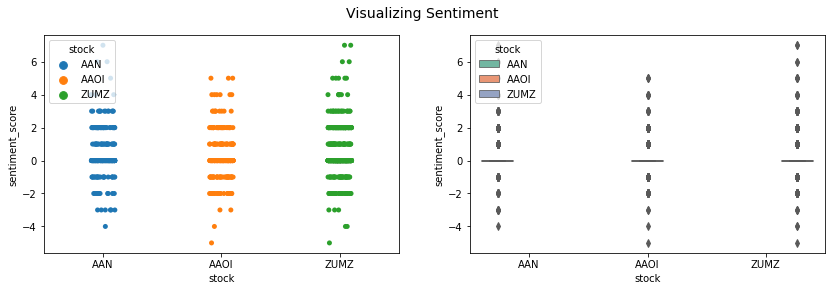

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='stock', y="sentiment_score", hue='stock', data=data, ax=ax1)
bp = sns.boxplot(x='stock', y="sentiment_score", hue='stock', data=data, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing Sentiment', fontsize=14)